# Homework №4
This homework will be dedicated to the Text-to-Speech(**TTS**), specifically the acoustic models.

# Data

    In this homework we will use only LJSpeech https://keithito.com/LJ-Speech-Dataset/.
    Use text from `Normalized Transcription` field in transcripts.csv.
    
    Use the following `featurizer` (his configuration is +- standard for this task):

In [1]:
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0
        
    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()
        
        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))
    

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """
        
        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [2]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

In [3]:
wav, sr = torchaudio.load('../week01/audio.wav')
mels = featurizer(wav)

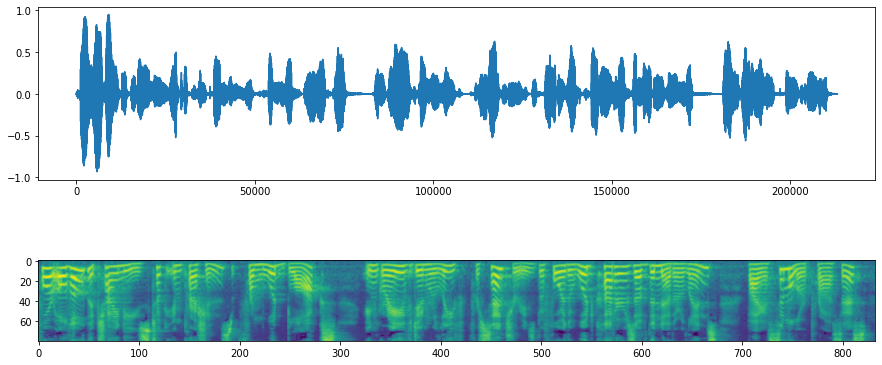

In [4]:
_, axes = plt.subplots(2, 1, figsize=(15, 7))
axes[0].plot(wav.squeeze())
axes[1].imshow(mels.squeeze())

plt.show()

### We will use pretrained Vocoder from Nvidia

In [ ]:
!git clone https://github.com/NVIDIA/waveglow.git

    Download pretrained model from https://github.com/NVIDIA/waveglow

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

### Use the following Vocoder for final quality validation

In [5]:
import sys
sys.path.append('waveglow/')

import warnings
warnings.filterwarnings('ignore')


class Vocoder(nn.Module):
    
    def __init__(self):
        super(Vocoder, self).__init__()
        
        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')['model']
        self.net = model.remove_weightnorm(model)
    
    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)
        
        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]
        
        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)
        
        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)
        
        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(spect.size(0), self.net.n_early_size, spect.size(2))
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)
        
        return audio

In [6]:
vocoder = Vocoder()
vocoder = vocoder.eval()

### Test pretrained vocoder

In [7]:
wav, sr = torchaudio.load('../week01/audio.wav')
mels = featurizer(wav)

reconstructed_wav = vocoder.inference(mels)

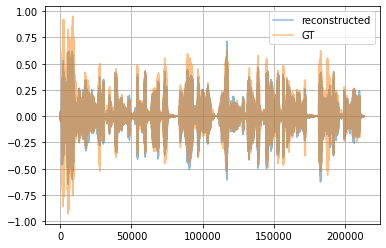

In [8]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(wav.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [9]:
display.Audio(reconstructed_wav.squeeze(), rate=22050)

In [10]:
display.Audio(wav.squeeze(), rate=22050)

# Model

    1) You need to implement Tacotron 2: https://www.dropbox.com/s/il9ai3ihh3nbcoo/Tacotron2.pdf?dl=0
    
    2) For fast convergence, implement Guided Attention: https://www.dropbox.com/s/tiibpqcdb1eieg4/GaidedAttention.pdf?dl=0
       It will increase convergence by several times!
    
    3) (Bonus) Implement Monotonic Attention: https://www.dropbox.com/s/6deupekgd4ep0kg/MonotonicAttention.pdf?dl=0
    
    4) (Bonus) Implement Tacotron with GST.
        For testing GST find 5-10 audio references with questioning tone and generate audio with this references.
        
    5) (PAY ATTENTION) Tacotron has RNNs, so don't forget about length masks.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!

    3) Good logging of experiments save your nerves and time, so we ask you to use W&B.
       Log loss, generated and real melspectrograms (in pair, i.e. real melspec and generated from correspond text). 
       Do not remove the logs until we have checked your work and given you a grade!

    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.

    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.

    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some melspec.

# Report

    Finally, you need to write a report in W&B https://www.wandb.com/reports. Add examples of generated mel and audio, compare with GT.
    Don't forget to add link to your report.